# Bayesian Modeling of Heart Disease

In [1]:
import pandas as pd
import numpy as np
import numpy.random as rnd
import seaborn as sns
from matplotlib import animation
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

## Load and Process Data

In [2]:
cleveland_hd=pd.read_csv("processed.cleveland.data",header=None)

In [3]:
cleveland_hd

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [4]:
# rename columns
cleveland_hd.columns=['age','sex','cp','trestbps','chol','fbs','restecg','thalach',
         'exang','oldpeak','slope','ca','thal','hd']

In [5]:
# convert chd 
cleveland_hd['hd']=[1 if hd > 0 else 0 for hd in cleveland_hd['hd']]
cleveland_hd

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [6]:
# remove missing values
cleveland_hd=cleveland_hd.replace('?',np.nan).dropna()
cleveland_hd

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1


In [7]:
cleveland_hd['cp'].value_counts()

4.0    142
3.0     83
2.0     49
1.0     23
Name: cp, dtype: int64

In [8]:
# convert categorical vars to ints
cleveland_hd['thal']=[int(float(cp)) for cp in cleveland_hd['thal']]
cleveland_hd['cp']=[int(float(cp)) for cp in cleveland_hd['cp']]
cleveland_hd['restecg']=[int(cp) for cp in cleveland_hd['restecg']]
cleveland_hd['slope']=[int(cp) for cp in cleveland_hd['slope']]
cleveland_hd['ca']=[int(float(cp)) for cp in cleveland_hd['ca']]

In [9]:
# encode categorical
cleveland_hd=pd.get_dummies(cleveland_hd, columns=['cp','ca','thal','restecg','slope'])
cleveland_hd

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,hd,cp_1,...,ca_3,thal_3,thal_6,thal_7,restecg_0,restecg_1,restecg_2,slope_1,slope_2,slope_3
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0,1,...,0,0,1,0,0,0,1,0,0,1
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,1,0,...,1,1,0,0,0,0,1,0,1,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,1,0,...,0,0,0,1,0,0,1,0,1,0
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0,0,...,0,1,0,0,1,0,0,0,0,1
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0,0,...,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,140.0,241.0,0.0,123.0,1.0,0.2,1,0,...,0,0,0,1,1,0,0,0,1,0
298,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,1,1,...,0,0,0,1,1,0,0,0,1,0
299,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,1,0,...,0,0,0,1,1,0,0,0,1,0
300,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,1,0,...,0,0,0,1,1,0,0,0,1,0


In [10]:
# standardize columns
for column in ['age','trestbps','chol','thalach']:
    mean=cleveland_hd[column].mean()
    print(mean)
    std=cleveland_hd[column].std()
    print(std)
    cleveland_hd[column]=[(val-mean)/std for val in cleveland_hd[column]]

54.54208754208754
9.049735681096765
131.69360269360268
17.762806366598998
247.35016835016836
51.99758253513897
149.5993265993266
22.941562061360813


In [11]:
# separate response from predictors
x=cleveland_hd.drop(['hd'],axis=1)

In [12]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297 entries, 0 to 301
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    float64
 1   sex        297 non-null    float64
 2   trestbps   297 non-null    float64
 3   chol       297 non-null    float64
 4   fbs        297 non-null    float64
 5   thalach    297 non-null    float64
 6   exang      297 non-null    float64
 7   oldpeak    297 non-null    float64
 8   cp_1       297 non-null    uint8  
 9   cp_2       297 non-null    uint8  
 10  cp_3       297 non-null    uint8  
 11  cp_4       297 non-null    uint8  
 12  ca_0       297 non-null    uint8  
 13  ca_1       297 non-null    uint8  
 14  ca_2       297 non-null    uint8  
 15  ca_3       297 non-null    uint8  
 16  thal_3     297 non-null    uint8  
 17  thal_6     297 non-null    uint8  
 18  thal_7     297 non-null    uint8  
 19  restecg_0  297 non-null    uint8  
 20  restecg_1 

In [13]:
# separate response from predictors
y=cleveland_hd['hd']

In [14]:
# split into train and test
X_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.1, random_state=42)

## Full Model

In [15]:
# full model with all predictors
with pm.Model() as hd_logit:
    X=pm.Data("X",X_train)
    α = pm.Normal('α', mu=0, sd=100) 
    β = pm.Normal('β',  mu=0, sd=100,shape=25)
    μ = α+pm.math.dot(X,β)
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=θ, observed=y_train)
    model_trace = pm.sample(2000, tune=1000, init='adapt_diag', cores=4, step=pm.NUTS(target_accept=0.99))

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████| 12000/12000 [09:15<00:00, 21.58draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


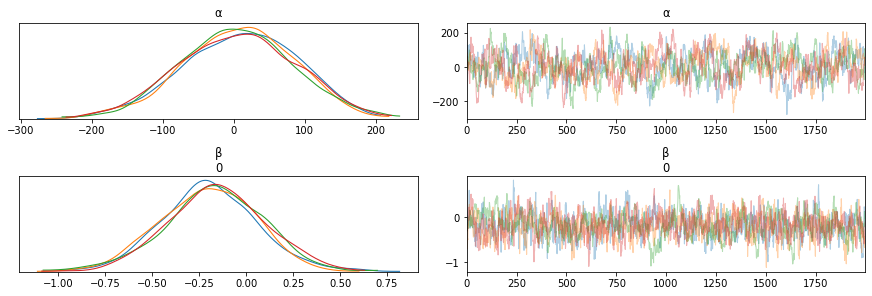

In [36]:
# examine trace plots
with hd_logit:
    az.plot_trace(model_trace, var_names=['α','β'])

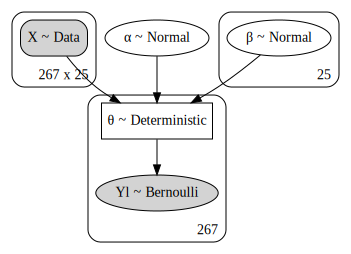

In [17]:
pm.model_to_graphviz(model=hd_logit)

In [18]:
# generate summary
s = pm.summary(model_trace,var_names=['β'])
s

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
β[0],-0.185,0.258,-0.654,0.315,0.011,0.008,569.0,569.0,572.0,894.0,1.01
β[1],1.908,0.620,0.790,3.129,0.023,0.017,713.0,691.0,716.0,1358.0,1.00
β[2],0.637,0.231,0.217,1.086,0.008,0.006,785.0,785.0,788.0,1285.0,1.00
β[3],0.324,0.242,-0.134,0.781,0.009,0.006,726.0,726.0,728.0,1381.0,1.00
β[4],-1.014,0.663,-2.224,0.281,0.021,0.015,1035.0,1035.0,1036.0,1985.0,1.00
β[5],-0.463,0.302,-1.020,0.108,0.012,0.009,601.0,601.0,602.0,1226.0,1.00
β[6],0.753,0.496,-0.178,1.680,0.015,0.011,1072.0,1072.0,1072.0,1973.0,1.00
β[7],0.420,0.271,-0.095,0.918,0.009,0.006,1010.0,1010.0,1010.0,1614.0,1.01
β[8],-10.438,46.340,-101.992,74.495,3.885,2.753,142.0,142.0,145.0,281.0,1.03
β[9],-8.411,46.331,-100.636,75.719,3.882,2.751,142.0,142.0,145.0,274.0,1.03


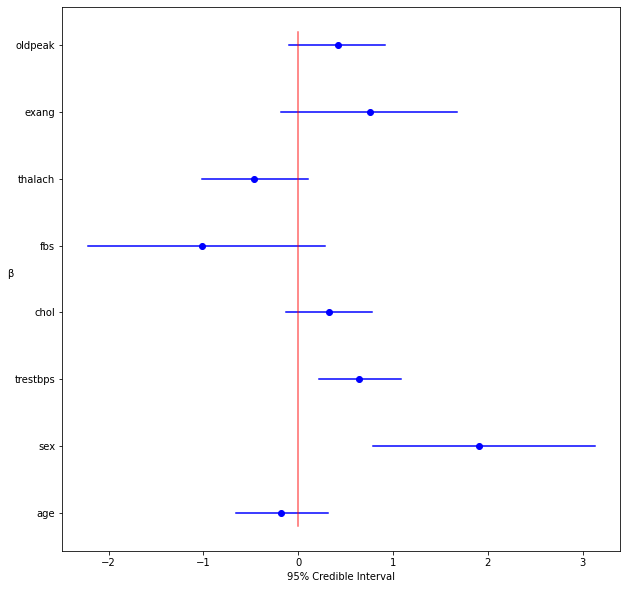

In [19]:
# forest plot for quantitative variables plus sex
fig = plt.figure(figsize=(10,10))

for i in range(8):
    plt.plot((s.iloc[i,2],s.iloc[i,3]),(i,i), color='blue')
    plt.scatter(s.iloc[i,0], i, color='blue')
    
plt.ylabel('β', rotation=0)
plt.xlabel('95% Credible Interval')
plt.plot((0,0),(-0.2,7.2), color='red',alpha=0.6)
plt.yticks(ticks=list(range(8)), labels=x.columns[0:9]);

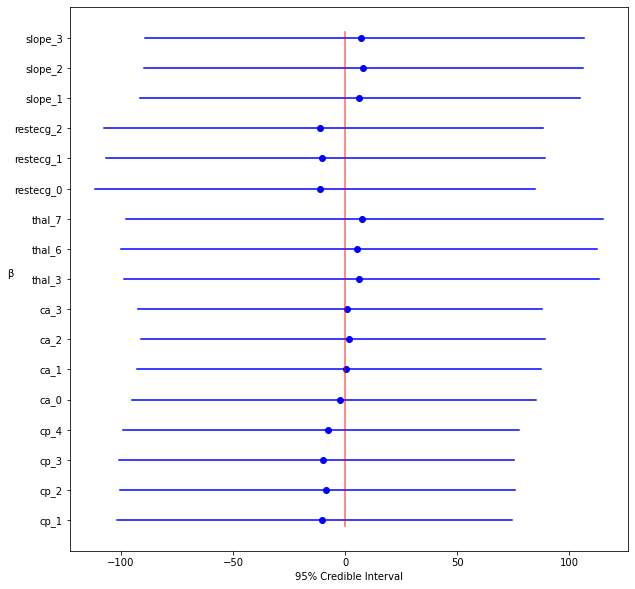

In [20]:
# forest plot for categorical vars
fig = plt.figure(figsize=(10,10))

for i in range(8,25):
    plt.plot((s.iloc[i,2],s.iloc[i,3]),(i,i), color='blue')
    plt.scatter(s.iloc[i,0], i, color='blue')
    
plt.ylabel('β', rotation=0)
plt.xlabel('95% Credible Interval')
plt.plot((0,0),(7.8,24.2), color='red',alpha=0.6)
plt.yticks(ticks=list(range(8,25)), labels=x.columns[8:]);

In [21]:
# generate posterior predictions on test set
with hd_logit:
    pm.set_data({"X": x_test})
    model_ppc = pm.sample_posterior_predictive(model_trace,var_names=['θ'], samples=10000)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3516.35it/s]


In [22]:
model_ppc

{'θ': array([[1.43585166e-02, 6.97905616e-01, 3.51349859e-04, ...,
         3.92190566e-01, 4.34120462e-01, 3.09086098e-02],
        [1.69040467e-02, 2.13094458e-01, 7.65807900e-04, ...,
         6.94051700e-01, 2.80046012e-01, 2.18288171e-02],
        [1.33729694e-02, 4.84445068e-01, 1.78557163e-04, ...,
         6.99370146e-01, 1.26500677e-01, 1.26886837e-02],
        ...,
        [3.89962050e-02, 7.46500238e-01, 5.99038152e-04, ...,
         5.68153536e-01, 2.37839576e-01, 3.30503443e-02],
        [2.14559024e-02, 4.92249020e-01, 8.42884254e-05, ...,
         7.66262571e-01, 1.24091535e-01, 3.62102786e-02],
        [1.10318455e-02, 4.36975571e-01, 3.45816037e-04, ...,
         6.52994555e-01, 2.44635253e-01, 2.83650453e-02]])}

In [23]:
# prediction distributions
prediction_df=pd.DataFrame({'actual':y_test,'prediction':model_ppc['θ'].mean(0).round(),'probability':model_ppc['θ'].mean(0),'lower bound':np.quantile(model_ppc['θ'],0.03,axis=0),'upper bound':np.quantile(model_ppc['θ'],0.97,axis=0)})
prediction_df

,actual,prediction,probability,lower bound,upper bound
169,0,0.0,0.034586,0.003564,0.122764
214,1,0.0,0.452432,0.162549,0.764065
63,0,0.0,0.001750,0.000103,0.007092
155,1,1.0,0.983642,0.924360,0.999420
5,0,0.0,0.049515,0.008865,0.139975
77,0,0.0,0.208685,0.030798,0.553447
185,0,0.0,0.285852,0.040365,0.712022
159,0,0.0,0.452337,0.129770,0.814869
9,1,1.0,0.823911,0.425856,0.987455
140,0,0.0,0.153806,0.025279,0.406993


In [28]:
# plot prediction uncertainty

plt.figure(figsize=(8,6))

blue_patch = mpatches.Patch(color='#00204C', label='Absence')
orange_patch = mpatches.Patch(color='orange', label='Presence')
for i in range(prediction_df.shape[0]):
    if prediction_df['actual'].iloc[i]==0:
        plt.plot(
            [i,i],
            az.hdi(model_ppc['θ'])[i], 
            lw=1,
            color="#00204C",
            alpha=0.8,
            )
    else:
        plt.plot(
            [i,i],
            az.hdi(model_ppc['θ'])[i], 
            lw=1,
            color="orange",
            alpha=0.8,
            )
plt.legend(handles=[blue_patch,orange_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("observation")
plt.ylabel("Probability")
plt.title("Understanding Uncertainty in Predictions")

AttributeError: module 'arviz' has no attribute 'hdi'

<Figure size 576x432 with 0 Axes>

In [25]:
# correct predictions
prediction_df.query('actual==prediction')

,actual,prediction,probability,lower bound,upper bound
169,0,0.0,0.034586,0.003564,0.122764
63,0,0.0,0.001750,0.000103,0.007092
155,1,1.0,0.983642,0.924360,0.999420
5,0,0.0,0.049515,0.008865,0.139975
77,0,0.0,0.208685,0.030798,0.553447
185,0,0.0,0.285852,0.040365,0.712022
159,0,0.0,0.452337,0.129770,0.814869
9,1,1.0,0.823911,0.425856,0.987455
140,0,0.0,0.153806,0.025279,0.406993
78,0,0.0,0.278525,0.065567,0.599958


In [26]:
# incorrect predictions
prediction_df.query('actual!=prediction')

,actual,prediction,probability,lower bound,upper bound
214,1,0.0,0.452432,0.162549,0.764065
290,1,0.0,0.483850,0.156687,0.815485
42,0,1.0,0.617387,0.195737,0.932626
33,0,1.0,0.749491,0.472629,0.932475
267,1,0.0,0.323272,0.039993,0.792161


In [27]:
# confusion matrix
pd.crosstab(prediction_df.actual,prediction_df.prediction)

prediction,0.0,1.0
actual,,
0,17,2
1,3,8


## Reduced Model

In [29]:
# reduced model with only quantitative variables plus sex
with pm.Model() as hd_reduced:
    X=pm.Data("X",X_train[['age','sex','trestbps','chol','fbs','thalach','exang','oldpeak']])
    α = pm.Normal('α', mu=0, sd=100) 
    β = pm.Normal('β',  mu=0, sd=100,shape=8)
    μ = α+pm.math.dot(X,β)
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=θ, observed=y_train)
    reduced_trace = pm.sample(2000, tune=1000, init='adapt_diag', cores=1, step=pm.NUTS(target_accept = 0.99))

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 12000/12000 [00:23<00:00, 503.67draws/s]


## Pseudo-Bayesian Model Averaging

In [30]:
# reset full model data to train
with hd_logit:
    pm.set_data({"X": X_train})

In [31]:
# compare results by WAIC to get weights for BMA
cmp_df = az.compare({'model_1':model_trace, 'model_2':reduced_trace}, ic = 'WAIC',
                    method='BB-pseudo-BMA')
weights = cmp_df['weight']

# generate predictions with BMA
y_bma = pm.sample_posterior_predictive_w(traces = [model_trace, reduced_trace],
                                        samples=8000,
                                        models=[hd_logit, hd_reduced],
                                        weights=weights)

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1470.58it/s]


In [32]:
cmp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_1,0,217.73,24.8375,0,0.981656,26.2647,0,True,deviance
model_2,1,268.401,9.54236,50.6706,0.018344,18.67,21.7507,True,deviance


In [33]:
# get posteriors for reduced model on test set predictions
with hd_reduced:
    pm.set_data({"X": x_test[['age','sex','trestbps','chol','fbs','thalach','exang','oldpeak']]})
    reduced_ppc = pm.sample_posterior_predictive(reduced_trace,var_names=['θ'], samples=10000)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 3295.98it/s]


In [34]:
# build dataframe to compute weighted posteriors and predictions
# store upper and lower bounds for each model
params = pd.DataFrame(np.hstack((az.hdi(model_ppc['θ']), az.hdi(reduced_ppc['θ']))))

# rename columns
params.columns = ['full_lb','full_ub','reduced_lb','reduced_ub']

# compute bounds for bma
params['bma_lb'] = weights[0]*params.full_lb + weights[1]*params.reduced_lb
params['bma_ub'] = weights[0]*params.full_ub + weights[1]*params.reduced_ub

# get probabilities for predictions of each model
params['full_prob'] = model_ppc['θ'].mean(0)
params['reduced_prob'] = reduced_ppc['θ'].mean(0)

# commpute probabilities for bma
params['bma_prob'] = weights[0]*params.full_prob + weights[1]*params.reduced_prob

# make binary classification for bma
params['pred'] = params.bma_prob.round()

# add true values
params['actual'] = list(y_test)

AttributeError: module 'arviz' has no attribute 'hdi'

In [ ]:
# plot uncertainty of test predictions with BMA
plt.figure(figsize=(8,6))

blue_patch = mpatches.Patch(color='#00204C', label='Absence')
orange_patch = mpatches.Patch(color='red', label='Presence')
for i in range(params.shape[0]):
    if params['actual'].iloc[i]==0:
        plt.plot(
            [i,i],
            [params.bma_lb[i], params.bma_ub[i]], 
            color="#00204C",
            alpha=0.8,
            linewidth=2
            )
        plt.scatter(i,
                   params.bma_prob[i],
                   color="#00204C",
                   s=15)
    else:
        plt.plot(
            [i,i],
            [params.bma_lb[i], params.bma_ub[i]],
            color="red",
            alpha=0.8,
            linewidth=2
            )
        plt.scatter(i,
                   params.bma_prob[i],
                   color='red',
                   s=15)
plt.legend(handles=[blue_patch,orange_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("observation")
plt.ylabel("Probability")
plt.title("Understanding Uncertainty in Predictions")
plt.plot((0,30),(0.5,0.5), color='black', alpha=0.6)

plt.savefig('bma_uncertainty.png');

In [ ]:
# plot same uncertainties for misclassified observations

params1=params.query('actual!=pred').reset_index(drop=True)
params1

plt.figure(figsize=(8,6))

blue_patch = mpatches.Patch(color='#00204C', label='Absence')
orange_patch = mpatches.Patch(color='red', label='Presence')
for i in range(params1.shape[0]):
    if params1['actual'].iloc[i]==0:
        plt.plot(
            [i,i],
            [params1.bma_lb[i], params1.bma_ub[i]], 
            color="#00204C",
            alpha=0.8,
            linewidth=2
            )
        plt.scatter(i,
                   params1.bma_prob[i],
                   color="#00204C")
    else:
        plt.plot(
            [i,i],
            [params1.bma_lb[i], params1.bma_ub[i]],
            color="red",
            alpha=0.8,
            linewidth=2
            )
        plt.scatter(i,
                   params1.bma_prob[i],
                   color='red')
plt.legend(handles=[blue_patch,orange_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel("observation")
plt.ylabel("Probability")
plt.title("Understanding Uncertainty in Predictions")
plt.plot((-0.2,4.2),(0.5,0.5), color='black', alpha=0.6)

plt.savefig('bma_uncertainty.png');

In [ ]:
# extract details for interesting result, observation 17
x_test.iloc[18,:]